In [ ]:
#ECGR 4106: Real-Time AI
#Michael Lust
#Homework 3
#March 29, 2022

In [ ]:
#Convolution online example:
#https://shonit2096.medium.com/cnn-on-cifar10-data-set-using-pytorch-34be87e09844
#Used to help construct CNN to clasify images across all 10 classes in CIFER10 

a. Build a Convolutional Neural Network, like what we built in lectures (without skip connections), to classify the images across all 10 classes in CIFAR 10. You need to adjust the fully connected layer at the end properly with respect to the number of output classes. Train your network for 300 epochs. Report your training time, training loss, and evaluation accuracy after 300 epochs. Analyze your results in your report and compare them against a fully connected network (homework 2) on training time, achieved accuracy, and model size. Make sure to submit your code by providing the GitHub URL of your course repository for this course.

In [ ]:
#Imports
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

#Pytorch imports
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda:0')
print(torch.cuda.is_available())

#Using google colab assigned GPU to train
#device = !nvidia-smi
#device = '\n'.join(device)
#if device.find('failed') >= 0:
  #print('Not connected to a GPU')
#else:
  #print(device)

True


In [ ]:
# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = 20

# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


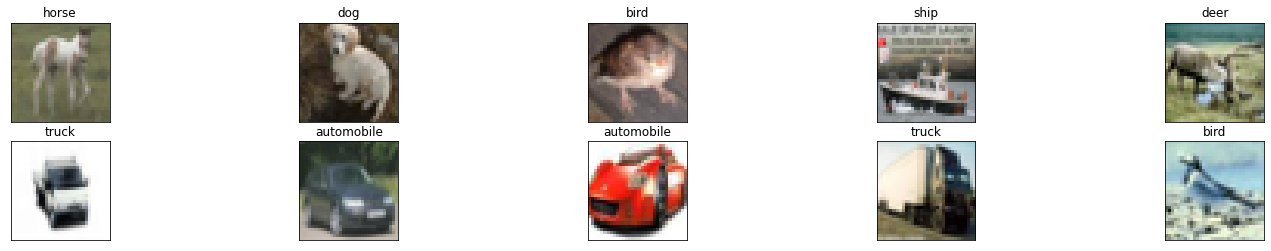

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))

# display 20 images
for idx in np.arange(10):
  ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
# define the CNN architecture
#Building class similar to: model = nn.Sequential from textbook example

#Online example
class Net1(nn.Module):
  def __init__(self):
    super(Net1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

#Textbook example
# class Net1(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
#         self.act1 = nn.Tanh()
#         self.pool1 = nn.MaxPool2d(2)
#         self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
#         self.act2 = nn.Tanh()
#         self.pool2 = nn.MaxPool2d(2)
#         self.fc1 = nn.Linear(8 * 8 * 8, 32) #The size of the first linear layer is dependent on the expected size of the output of MaxPool2d: 8 × 8 × 8 = 512. 
#         self.act3 = nn.Tanh()
#         self.fc2 = nn.Linear(32, 2)

    # def forward(self, x):
    #     out = self.pool1(self.act1(self.conv1(x)))
    #     out = self.pool2(self.act2(self.conv2(out)))
    #     out = out.view(-1, 8 * 8 * 8) # <1> Forwarding the inputs of the model and reshaping it to return the output
    #     out = self.act3(self.fc1(out))
    #     out = self.fc2(out)
    #     return out

# create a complete CNN
model1 = Net1()
if torch.cuda.is_available():
    model1.cuda()
print(model1)

numel_list = [p.numel() for p in model1.parameters()]
sum(numel_list), numel_list

Net1(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


(62006, [450, 6, 2400, 16, 48000, 120, 10080, 84, 840, 10])

In [ ]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model1.parameters(), lr=.01)

In [ ]:
%%time
from tqdm import tqdm
#to record model runtime
# number of epochs to train the model
n_epochs = 300 #Needs to be 300

#List to store loss to visualize
train_losslist = []

# track change in validation loss
valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):
  if epoch == 1 or epoch % 30 == 0: 
    print('\nEpoch: {}'.format(epoch))

  # keep track of training and validation loss
  train_loss = 0.0
  valid_loss = 0.0

  if epoch == 1 or epoch % 30 == 0: 
    print('training: ')  

  with tqdm(train_loader, unit="batch") as tepoch:  
    # train the model
    model1.train()
    for data, target in tepoch:

        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model1(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss
        train_loss += loss.item()*data.size(0)

  if epoch == 1 or epoch % 30 == 0:       
   print('validation: ')      

  with tqdm(valid_loader, unit="batch") as vepoch:
    # validate the model
    model1.eval()
    for data, target in vepoch:

        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model1(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
  # calculate average losses
  train_loss = train_loss/len(train_loader.dataset)
  valid_loss = valid_loss/len(valid_loader.dataset)
  train_losslist.append(train_loss)
        
  # print training/validation statistics 
  if epoch == 1 or epoch % 30 == 0: 
    print('Training Loss: {:.6f} \tValidation Loss: {:.6f}'.format(train_loss, valid_loss))
  
  # save model if validation loss has decreased
  if epoch == 1 or epoch % 30 == 0: 
    if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_loss_min,
      valid_loss))
      torch.save(model1.state_dict(), 'model_cifar.pt')
      valid_loss_min = valid_loss

# plt.plot(n_epochs, train_losslist)
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Performance of Model 1")
# plt.show()


Epoch: 1
training: 


100%|██████████| 2000/2000 [00:17<00:00, 115.75batch/s]


validation: 


100%|██████████| 500/500 [00:03<00:00, 149.49batch/s]


Training Loss: 1.738140 	Validation Loss: 0.382443
Validation loss decreased (inf --> 0.382443).  Saving model ...


100%|██████████| 500/500 [00:03<00:00, 143.17batch/s]



Epoch: 30
training: 


100%|██████████| 2000/2000 [00:17<00:00, 116.08batch/s]


validation: 


100%|██████████| 500/500 [00:03<00:00, 145.92batch/s]


Training Loss: 0.408580 	Validation Loss: 0.260559
Validation loss decreased (0.382443 --> 0.260559).  Saving model ...


100%|██████████| 500/500 [00:03<00:00, 147.80batch/s]



Epoch: 60
training: 


100%|██████████| 2000/2000 [00:16<00:00, 119.31batch/s]


validation: 


100%|██████████| 500/500 [00:03<00:00, 147.90batch/s]


Training Loss: 0.177685 	Validation Loss: 0.513600


100%|██████████| 500/500 [00:03<00:00, 147.15batch/s]



Epoch: 90
training: 


100%|██████████| 2000/2000 [00:17<00:00, 116.30batch/s]


validation: 


100%|██████████| 500/500 [00:03<00:00, 145.51batch/s]


Training Loss: 0.122517 	Validation Loss: 0.742945


100%|██████████| 500/500 [00:03<00:00, 148.91batch/s]



Epoch: 120
training: 


100%|██████████| 2000/2000 [00:17<00:00, 116.77batch/s]


validation: 


100%|██████████| 500/500 [00:03<00:00, 143.82batch/s]


Training Loss: 0.092176 	Validation Loss: 0.891858


100%|██████████| 500/500 [00:03<00:00, 144.04batch/s]



Epoch: 150
training: 


100%|██████████| 2000/2000 [00:17<00:00, 115.04batch/s]


validation: 


100%|██████████| 500/500 [00:03<00:00, 144.73batch/s]


Training Loss: 0.123462 	Validation Loss: 0.981325


100%|██████████| 500/500 [00:03<00:00, 151.67batch/s]



Epoch: 180
training: 


100%|██████████| 2000/2000 [00:16<00:00, 118.37batch/s]


validation: 


100%|██████████| 500/500 [00:03<00:00, 145.93batch/s]


Training Loss: 0.104748 	Validation Loss: 1.120295


100%|██████████| 500/500 [00:03<00:00, 144.12batch/s]



Epoch: 210
training: 


100%|██████████| 2000/2000 [00:16<00:00, 117.91batch/s]


validation: 


100%|██████████| 500/500 [00:03<00:00, 145.06batch/s]


Training Loss: 0.074405 	Validation Loss: 1.217253


100%|██████████| 500/500 [00:03<00:00, 149.65batch/s]



Epoch: 240
training: 


100%|██████████| 2000/2000 [00:17<00:00, 116.84batch/s]


validation: 


100%|██████████| 500/500 [00:03<00:00, 146.29batch/s]


Training Loss: 0.084083 	Validation Loss: 1.276952


100%|██████████| 500/500 [00:03<00:00, 146.77batch/s]



Epoch: 270
training: 


100%|██████████| 2000/2000 [00:16<00:00, 118.92batch/s]


validation: 


100%|██████████| 500/500 [00:03<00:00, 148.26batch/s]


Training Loss: 0.083079 	Validation Loss: 1.353036


100%|██████████| 500/500 [00:03<00:00, 142.59batch/s]



Epoch: 300
training: 


100%|██████████| 2000/2000 [00:17<00:00, 113.34batch/s]


validation: 


100%|██████████| 500/500 [00:03<00:00, 143.25batch/s]

Training Loss: 0.095324 	Validation Loss: 1.420534
CPU times: user 1h 40min 28s, sys: 1min 59s, total: 1h 42min 27s
Wall time: 1h 42min 52s


In [ ]:
model1.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model1.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model1(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not device else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.326645

Test Accuracy of airplane: 71% (710/1000)
Test Accuracy of automobile: 83% (830/1000)
Test Accuracy of  bird: 48% (489/1000)
Test Accuracy of   cat: 41% (416/1000)
Test Accuracy of  deer: 54% (542/1000)
Test Accuracy of   dog: 57% (572/1000)
Test Accuracy of  frog: 69% (693/1000)
Test Accuracy of horse: 66% (667/1000)
Test Accuracy of  ship: 69% (699/1000)
Test Accuracy of truck: 72% (727/1000)

Test Accuracy (Overall): 63% (6345/10000)


#### b. Extend your CNN by adding one more additional convolution layer followed by an activation function and pooling function. You also need to adjust your fully connected layer properly with respect to intermediate feature dimensions. Train your network for 300 epochs. Report your training time, loss, and evaluation accuracy after 300 epochs. Analyze your results in your report and compare your model size and accuracy over the baseline implementation in Problem1.a. Do you see any over-fitting? Make sure to submit your code by providing the GitHub URL of your course repository for this course.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture
#Building class similar to: model = nn.Sequential from textbook example but for convolution

#Online example
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) #Adding one more layer to compare to Net1
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x))) #Adding one more layer to compare to Net1
        # flattening
        x = x.view(-1, 64 * 4 * 4)
        # fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# create a complete CNN
model2 = Net2()
if torch.cuda.is_available():
    model2.cuda()
print(model2)

numel_list = [p.numel() for p in model2.parameters()]
sum(numel_list), numel_list

Net2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


(581866, [432, 16, 4608, 32, 18432, 64, 524288, 512, 32768, 64, 640, 10])

In [ ]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model2.parameters(), lr=.01)

In [ ]:
%%time
from tqdm import tqdm

# number of epochs to train the model
n_epochs = 300 #Needs to be 300

#List to store loss to visualize
train_losslist = []

# track change in validation loss
valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):
  print('\nEpoch: {}'.format(epoch))

  # keep track of training and validation loss
  train_loss = 0.0
  valid_loss = 0.0

  if epoch == 1 or epoch % 30 == 0: 
    print('training: ') 

  with tqdm(train_loader, unit="batch") as tepoch:  
    # train the model
    model2.train()
    for data, target in tepoch:

        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model2(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss
        train_loss += loss.item()*data.size(0)

  if epoch == 1 or epoch % 30 == 0:      
    print('validation: ')     

  with tqdm(valid_loader, unit="batch") as vepoch:
    # validate the model
    model2.eval()
    for data, target in vepoch:

        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model2(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
  # calculate average losses
  train_loss = train_loss/len(train_loader.dataset)
  valid_loss = valid_loss/len(valid_loader.dataset)
  train_losslist.append(train_loss)
        
  # print training/validation statistics
  if epoch == 1 or epoch % 30 == 0: 
    print('Training Loss: {:.6f} \tValidation Loss: {:.6f}'.format(train_loss, valid_loss))

  # save model if validation loss has decreased
  if epoch == 1 or epoch % 30 == 0: 
    if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_loss_min,
      valid_loss))
      torch.save(model2.state_dict(), 'model_cifar.pt')
      valid_loss_min = valid_loss

# plt.plot(n_epochs, train_losslist)
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Performance of Model 1")
# plt.show()


Epoch: 1
training: 


100%|██████████| 2000/2000 [00:19<00:00, 102.61batch/s]


validation: 


100%|██████████| 500/500 [00:03<00:00, 136.50batch/s]


Training Loss: 1.826530 	Validation Loss: 0.436309
Validation loss decreased (inf --> 0.436309).  Saving model ...

Epoch: 2


100%|██████████| 500/500 [00:03<00:00, 138.50batch/s]



Epoch: 3


100%|██████████| 500/500 [00:03<00:00, 139.20batch/s]



Epoch: 4


100%|██████████| 500/500 [00:03<00:00, 138.69batch/s]



Epoch: 5


100%|██████████| 500/500 [00:03<00:00, 135.71batch/s]



Epoch: 6


100%|██████████| 500/500 [00:03<00:00, 129.71batch/s]



Epoch: 7


100%|██████████| 500/500 [00:03<00:00, 136.30batch/s]



Epoch: 8


100%|██████████| 500/500 [00:03<00:00, 137.15batch/s]



Epoch: 9


100%|██████████| 500/500 [00:03<00:00, 130.34batch/s]



Epoch: 10


100%|██████████| 500/500 [00:03<00:00, 139.87batch/s]



Epoch: 11


100%|██████████| 500/500 [00:03<00:00, 136.49batch/s]



Epoch: 12


100%|██████████| 500/500 [00:03<00:00, 137.58batch/s]



Epoch: 13


100%|██████████| 500/500 [00:03<00:00, 137.77batch/s]



Epoch: 14


100%|██████████| 500/500 [00:03<00:00, 137.17batch/s]



Epoch: 15


100%|██████████| 500/500 [00:03<00:00, 137.39batch/s]



Epoch: 16


100%|██████████| 500/500 [00:03<00:00, 137.42batch/s]



Epoch: 17


100%|██████████| 500/500 [00:03<00:00, 136.99batch/s]



Epoch: 18


100%|██████████| 500/500 [00:03<00:00, 134.52batch/s]



Epoch: 19


100%|██████████| 500/500 [00:03<00:00, 137.97batch/s]



Epoch: 20


100%|██████████| 500/500 [00:03<00:00, 136.70batch/s]



Epoch: 21


100%|██████████| 500/500 [00:03<00:00, 135.65batch/s]



Epoch: 22


100%|██████████| 500/500 [00:03<00:00, 135.83batch/s]



Epoch: 23


100%|██████████| 500/500 [00:03<00:00, 137.48batch/s]



Epoch: 24


100%|██████████| 500/500 [00:03<00:00, 137.41batch/s]



Epoch: 25


100%|██████████| 500/500 [00:03<00:00, 137.54batch/s]



Epoch: 26


100%|██████████| 500/500 [00:03<00:00, 135.66batch/s]



Epoch: 27


100%|██████████| 500/500 [00:03<00:00, 138.30batch/s]



Epoch: 28


100%|██████████| 500/500 [00:03<00:00, 129.50batch/s]



Epoch: 29


100%|██████████| 500/500 [00:03<00:00, 138.68batch/s]



Epoch: 30
training: 


100%|██████████| 2000/2000 [00:19<00:00, 104.41batch/s]


validation: 


100%|██████████| 500/500 [00:03<00:00, 138.00batch/s]


Training Loss: 0.408897 	Validation Loss: 0.159980
Validation loss decreased (0.436309 --> 0.159980).  Saving model ...

Epoch: 31


100%|██████████| 500/500 [00:03<00:00, 137.20batch/s]



Epoch: 32


100%|██████████| 500/500 [00:03<00:00, 135.91batch/s]



Epoch: 33


100%|██████████| 500/500 [00:03<00:00, 134.90batch/s]



Epoch: 34


100%|██████████| 500/500 [00:03<00:00, 139.08batch/s]



Epoch: 35


100%|██████████| 500/500 [00:03<00:00, 134.97batch/s]



Epoch: 36


100%|██████████| 500/500 [00:03<00:00, 135.14batch/s]



Epoch: 37


100%|██████████| 500/500 [00:03<00:00, 134.91batch/s]



Epoch: 38


100%|██████████| 500/500 [00:03<00:00, 135.85batch/s]



Epoch: 39


100%|██████████| 500/500 [00:03<00:00, 138.35batch/s]



Epoch: 40


100%|██████████| 500/500 [00:03<00:00, 135.26batch/s]



Epoch: 41


100%|██████████| 500/500 [00:03<00:00, 133.52batch/s]



Epoch: 42


100%|██████████| 500/500 [00:03<00:00, 134.26batch/s]



Epoch: 43


100%|██████████| 500/500 [00:03<00:00, 136.29batch/s]



Epoch: 44


100%|██████████| 500/500 [00:03<00:00, 137.46batch/s]



Epoch: 45


100%|██████████| 500/500 [00:03<00:00, 137.13batch/s]



Epoch: 46


100%|██████████| 500/500 [00:03<00:00, 137.20batch/s]



Epoch: 47


100%|██████████| 500/500 [00:03<00:00, 137.38batch/s]



Epoch: 48


100%|██████████| 500/500 [00:03<00:00, 135.80batch/s]



Epoch: 49


100%|██████████| 500/500 [00:03<00:00, 134.91batch/s]



Epoch: 50


100%|██████████| 500/500 [00:03<00:00, 136.39batch/s]



Epoch: 51


100%|██████████| 500/500 [00:03<00:00, 137.50batch/s]



Epoch: 52


100%|██████████| 500/500 [00:03<00:00, 134.91batch/s]



Epoch: 53


100%|██████████| 500/500 [00:03<00:00, 137.22batch/s]



Epoch: 54


100%|██████████| 500/500 [00:03<00:00, 133.17batch/s]



Epoch: 55


100%|██████████| 500/500 [00:03<00:00, 138.01batch/s]



Epoch: 56


100%|██████████| 500/500 [00:03<00:00, 136.47batch/s]



Epoch: 57


100%|██████████| 500/500 [00:03<00:00, 136.97batch/s]



Epoch: 58


100%|██████████| 500/500 [00:03<00:00, 127.99batch/s]



Epoch: 59


100%|██████████| 500/500 [00:03<00:00, 132.29batch/s]



Epoch: 60
training: 


100%|██████████| 2000/2000 [00:19<00:00, 102.74batch/s]


validation: 


100%|██████████| 500/500 [00:03<00:00, 138.41batch/s]


Training Loss: 0.152393 	Validation Loss: 0.242144

Epoch: 61


100%|██████████| 500/500 [00:03<00:00, 136.90batch/s]



Epoch: 62


100%|██████████| 500/500 [00:03<00:00, 135.13batch/s]



Epoch: 63


100%|██████████| 500/500 [00:03<00:00, 135.96batch/s]



Epoch: 64


100%|██████████| 500/500 [00:03<00:00, 135.05batch/s]



Epoch: 65


100%|██████████| 500/500 [00:03<00:00, 136.77batch/s]



Epoch: 66


100%|██████████| 500/500 [00:03<00:00, 135.71batch/s]



Epoch: 67


100%|██████████| 500/500 [00:03<00:00, 135.78batch/s]



Epoch: 68


100%|██████████| 500/500 [00:03<00:00, 134.29batch/s]



Epoch: 69


100%|██████████| 500/500 [00:03<00:00, 137.63batch/s]



Epoch: 70


100%|██████████| 500/500 [00:03<00:00, 136.29batch/s]



Epoch: 71


100%|██████████| 500/500 [00:03<00:00, 135.89batch/s]



Epoch: 72


100%|██████████| 500/500 [00:03<00:00, 137.20batch/s]



Epoch: 73


100%|██████████| 500/500 [00:03<00:00, 134.91batch/s]



Epoch: 74


100%|██████████| 500/500 [00:03<00:00, 136.43batch/s]



Epoch: 75


100%|██████████| 500/500 [00:03<00:00, 137.04batch/s]



Epoch: 76


100%|██████████| 500/500 [00:03<00:00, 136.50batch/s]



Epoch: 77


100%|██████████| 500/500 [00:03<00:00, 135.95batch/s]



Epoch: 78


100%|██████████| 500/500 [00:03<00:00, 136.03batch/s]



Epoch: 79


100%|██████████| 500/500 [00:03<00:00, 134.54batch/s]



Epoch: 80


100%|██████████| 500/500 [00:03<00:00, 136.78batch/s]



Epoch: 81


100%|██████████| 500/500 [00:03<00:00, 135.52batch/s]



Epoch: 82


100%|██████████| 500/500 [00:03<00:00, 136.12batch/s]



Epoch: 83


100%|██████████| 500/500 [00:03<00:00, 136.49batch/s]



Epoch: 84


100%|██████████| 500/500 [00:03<00:00, 135.85batch/s]



Epoch: 85


100%|██████████| 500/500 [00:03<00:00, 137.02batch/s]



Epoch: 86


100%|██████████| 500/500 [00:03<00:00, 137.17batch/s]



Epoch: 87


100%|██████████| 500/500 [00:03<00:00, 132.67batch/s]



Epoch: 88


100%|██████████| 500/500 [00:03<00:00, 136.07batch/s]



Epoch: 89


100%|██████████| 500/500 [00:03<00:00, 134.42batch/s]



Epoch: 90
training: 


100%|██████████| 2000/2000 [00:19<00:00, 103.82batch/s]


validation: 


100%|██████████| 500/500 [00:03<00:00, 134.31batch/s]


Training Loss: 0.095815 	Validation Loss: 0.290949

Epoch: 91


100%|██████████| 500/500 [00:03<00:00, 136.51batch/s]



Epoch: 92


100%|██████████| 500/500 [00:03<00:00, 137.65batch/s]



Epoch: 93


100%|██████████| 500/500 [00:03<00:00, 136.77batch/s]



Epoch: 94


100%|██████████| 500/500 [00:03<00:00, 134.75batch/s]



Epoch: 95


100%|██████████| 500/500 [00:03<00:00, 135.26batch/s]



Epoch: 96


100%|██████████| 500/500 [00:03<00:00, 132.57batch/s]



Epoch: 97


100%|██████████| 500/500 [00:03<00:00, 135.23batch/s]



Epoch: 98


100%|██████████| 500/500 [00:03<00:00, 137.49batch/s]



Epoch: 99


100%|██████████| 500/500 [00:03<00:00, 137.03batch/s]



Epoch: 100


100%|██████████| 500/500 [00:03<00:00, 136.04batch/s]



Epoch: 101


100%|██████████| 500/500 [00:03<00:00, 136.98batch/s]



Epoch: 102


100%|██████████| 500/500 [00:03<00:00, 137.01batch/s]



Epoch: 103


100%|██████████| 500/500 [00:03<00:00, 137.65batch/s]



Epoch: 104


100%|██████████| 500/500 [00:03<00:00, 134.14batch/s]



Epoch: 105


100%|██████████| 500/500 [00:03<00:00, 134.03batch/s]



Epoch: 106


100%|██████████| 500/500 [00:03<00:00, 136.37batch/s]



Epoch: 107


100%|██████████| 500/500 [00:03<00:00, 135.83batch/s]



Epoch: 108


100%|██████████| 500/500 [00:03<00:00, 135.81batch/s]



Epoch: 109


100%|██████████| 500/500 [00:03<00:00, 134.39batch/s]



Epoch: 110


100%|██████████| 500/500 [00:03<00:00, 135.78batch/s]



Epoch: 111


100%|██████████| 500/500 [00:03<00:00, 131.05batch/s]



Epoch: 112


100%|██████████| 500/500 [00:03<00:00, 137.20batch/s]



Epoch: 113


100%|██████████| 500/500 [00:03<00:00, 135.63batch/s]



Epoch: 114


100%|██████████| 500/500 [00:03<00:00, 136.35batch/s]



Epoch: 115


100%|██████████| 500/500 [00:03<00:00, 135.94batch/s]



Epoch: 116


100%|██████████| 500/500 [00:03<00:00, 134.51batch/s]



Epoch: 117


100%|██████████| 500/500 [00:03<00:00, 133.42batch/s]



Epoch: 118


100%|██████████| 500/500 [00:03<00:00, 134.51batch/s]



Epoch: 119


100%|██████████| 500/500 [00:03<00:00, 134.15batch/s]



Epoch: 120
training: 


100%|██████████| 2000/2000 [00:19<00:00, 101.63batch/s]


validation: 


100%|██████████| 500/500 [00:03<00:00, 133.35batch/s]


Training Loss: 0.078326 	Validation Loss: 0.325293

Epoch: 121


100%|██████████| 500/500 [00:03<00:00, 134.89batch/s]



Epoch: 122


100%|██████████| 500/500 [00:03<00:00, 136.83batch/s]



Epoch: 123


100%|██████████| 500/500 [00:03<00:00, 137.69batch/s]



Epoch: 124


100%|██████████| 500/500 [00:03<00:00, 136.19batch/s]



Epoch: 125


100%|██████████| 500/500 [00:03<00:00, 135.26batch/s]



Epoch: 126


100%|██████████| 500/500 [00:03<00:00, 133.17batch/s]



Epoch: 127


100%|██████████| 500/500 [00:03<00:00, 133.44batch/s]



Epoch: 128


100%|██████████| 500/500 [00:03<00:00, 134.65batch/s]



Epoch: 129


100%|██████████| 500/500 [00:03<00:00, 135.80batch/s]



Epoch: 130


100%|██████████| 500/500 [00:03<00:00, 135.86batch/s]



Epoch: 131


100%|██████████| 500/500 [00:03<00:00, 137.58batch/s]



Epoch: 132


100%|██████████| 500/500 [00:03<00:00, 133.59batch/s]



Epoch: 133


100%|██████████| 500/500 [00:03<00:00, 135.42batch/s]



Epoch: 134


100%|██████████| 500/500 [00:03<00:00, 136.19batch/s]



Epoch: 135


100%|██████████| 500/500 [00:03<00:00, 135.42batch/s]



Epoch: 136


100%|██████████| 500/500 [00:03<00:00, 133.94batch/s]



Epoch: 137


100%|██████████| 500/500 [00:03<00:00, 131.72batch/s]



Epoch: 138


100%|██████████| 500/500 [00:03<00:00, 134.23batch/s]



Epoch: 139


100%|██████████| 500/500 [00:03<00:00, 133.83batch/s]



Epoch: 140


100%|██████████| 500/500 [00:03<00:00, 133.72batch/s]



Epoch: 141


100%|██████████| 500/500 [00:03<00:00, 134.44batch/s]



Epoch: 142


100%|██████████| 500/500 [00:03<00:00, 134.56batch/s]



Epoch: 143


100%|██████████| 500/500 [00:03<00:00, 138.20batch/s]



Epoch: 144


100%|██████████| 500/500 [00:03<00:00, 134.97batch/s]



Epoch: 145


100%|██████████| 500/500 [00:03<00:00, 137.11batch/s]



Epoch: 146


100%|██████████| 500/500 [00:03<00:00, 133.40batch/s]



Epoch: 147


100%|██████████| 500/500 [00:03<00:00, 134.44batch/s]



Epoch: 148


100%|██████████| 500/500 [00:03<00:00, 134.85batch/s]



Epoch: 149


100%|██████████| 500/500 [00:03<00:00, 135.08batch/s]



Epoch: 150
training: 


100%|██████████| 2000/2000 [00:19<00:00, 102.76batch/s]


validation: 


100%|██████████| 500/500 [00:03<00:00, 135.05batch/s]


Training Loss: 0.062563 	Validation Loss: 0.378184

Epoch: 151


100%|██████████| 500/500 [00:03<00:00, 136.92batch/s]



Epoch: 152


100%|██████████| 500/500 [00:03<00:00, 133.26batch/s]



Epoch: 153


100%|██████████| 500/500 [00:03<00:00, 136.38batch/s]



Epoch: 154


100%|██████████| 500/500 [00:03<00:00, 134.78batch/s]



Epoch: 155


100%|██████████| 500/500 [00:03<00:00, 135.45batch/s]



Epoch: 156


100%|██████████| 500/500 [00:03<00:00, 132.86batch/s]



Epoch: 157


100%|██████████| 500/500 [00:03<00:00, 132.63batch/s]



Epoch: 158


100%|██████████| 500/500 [00:03<00:00, 136.25batch/s]



Epoch: 159


100%|██████████| 500/500 [00:03<00:00, 136.54batch/s]



Epoch: 160


100%|██████████| 500/500 [00:03<00:00, 134.88batch/s]



Epoch: 161


100%|██████████| 500/500 [00:03<00:00, 133.71batch/s]



Epoch: 162


100%|██████████| 500/500 [00:03<00:00, 134.74batch/s]



Epoch: 163


100%|██████████| 500/500 [00:03<00:00, 133.99batch/s]



Epoch: 164


100%|██████████| 500/500 [00:03<00:00, 127.70batch/s]



Epoch: 165


100%|██████████| 500/500 [00:03<00:00, 133.61batch/s]



Epoch: 166


100%|██████████| 500/500 [00:03<00:00, 135.35batch/s]



Epoch: 167


100%|██████████| 500/500 [00:03<00:00, 133.00batch/s]



Epoch: 168


100%|██████████| 500/500 [00:03<00:00, 134.43batch/s]



Epoch: 169


100%|██████████| 500/500 [00:03<00:00, 138.15batch/s]



Epoch: 170


100%|██████████| 500/500 [00:03<00:00, 133.24batch/s]



Epoch: 171


100%|██████████| 500/500 [00:03<00:00, 134.88batch/s]



Epoch: 172


100%|██████████| 500/500 [00:03<00:00, 135.93batch/s]



Epoch: 173


100%|██████████| 500/500 [00:03<00:00, 132.83batch/s]



Epoch: 174


100%|██████████| 500/500 [00:03<00:00, 134.82batch/s]



Epoch: 175


100%|██████████| 500/500 [00:03<00:00, 133.37batch/s]



Epoch: 176


100%|██████████| 500/500 [00:03<00:00, 134.40batch/s]



Epoch: 177


100%|██████████| 500/500 [00:03<00:00, 134.45batch/s]



Epoch: 178


100%|██████████| 500/500 [00:03<00:00, 134.29batch/s]



Epoch: 179


100%|██████████| 500/500 [00:03<00:00, 134.54batch/s]



Epoch: 180
training: 


100%|██████████| 2000/2000 [00:19<00:00, 103.03batch/s]


validation: 


100%|██████████| 500/500 [00:03<00:00, 136.16batch/s]


Training Loss: 0.050636 	Validation Loss: 0.415187

Epoch: 181


100%|██████████| 500/500 [00:03<00:00, 135.67batch/s]



Epoch: 182


100%|██████████| 500/500 [00:03<00:00, 135.96batch/s]



Epoch: 183


100%|██████████| 500/500 [00:03<00:00, 134.67batch/s]



Epoch: 184


100%|██████████| 500/500 [00:03<00:00, 134.85batch/s]



Epoch: 185


100%|██████████| 500/500 [00:03<00:00, 133.69batch/s]



Epoch: 186


100%|██████████| 500/500 [00:03<00:00, 133.02batch/s]



Epoch: 187


100%|██████████| 500/500 [00:03<00:00, 134.13batch/s]



Epoch: 188


100%|██████████| 500/500 [00:03<00:00, 133.88batch/s]



Epoch: 189


100%|██████████| 500/500 [00:03<00:00, 135.00batch/s]



Epoch: 190


100%|██████████| 500/500 [00:03<00:00, 135.66batch/s]



Epoch: 191


100%|██████████| 500/500 [00:03<00:00, 135.58batch/s]



Epoch: 192


100%|██████████| 500/500 [00:03<00:00, 138.39batch/s]



Epoch: 193


100%|██████████| 500/500 [00:03<00:00, 137.51batch/s]



Epoch: 194


100%|██████████| 500/500 [00:03<00:00, 137.94batch/s]



Epoch: 195


100%|██████████| 500/500 [00:03<00:00, 138.20batch/s]



Epoch: 196


100%|██████████| 500/500 [00:03<00:00, 137.09batch/s]



Epoch: 197


100%|██████████| 500/500 [00:03<00:00, 134.60batch/s]



Epoch: 198


100%|██████████| 500/500 [00:03<00:00, 135.69batch/s]



Epoch: 199


100%|██████████| 500/500 [00:03<00:00, 133.00batch/s]



Epoch: 200


100%|██████████| 500/500 [00:03<00:00, 135.82batch/s]



Epoch: 201


100%|██████████| 500/500 [00:03<00:00, 134.97batch/s]



Epoch: 202


100%|██████████| 500/500 [00:03<00:00, 136.03batch/s]



Epoch: 203


100%|██████████| 500/500 [00:03<00:00, 135.59batch/s]



Epoch: 204


100%|██████████| 500/500 [00:03<00:00, 134.97batch/s]



Epoch: 205


100%|██████████| 500/500 [00:03<00:00, 134.49batch/s]



Epoch: 206


100%|██████████| 500/500 [00:03<00:00, 135.80batch/s]



Epoch: 207


100%|██████████| 500/500 [00:03<00:00, 135.18batch/s]



Epoch: 208


100%|██████████| 500/500 [00:03<00:00, 136.16batch/s]



Epoch: 209


100%|██████████| 500/500 [00:03<00:00, 134.09batch/s]



Epoch: 210
training: 


100%|██████████| 2000/2000 [00:19<00:00, 102.53batch/s]


validation: 


100%|██████████| 500/500 [00:03<00:00, 134.94batch/s]


Training Loss: 0.045814 	Validation Loss: 0.434302

Epoch: 211


100%|██████████| 500/500 [00:03<00:00, 136.17batch/s]



Epoch: 212


100%|██████████| 500/500 [00:03<00:00, 134.76batch/s]



Epoch: 213


100%|██████████| 500/500 [00:03<00:00, 131.16batch/s]



Epoch: 214


100%|██████████| 500/500 [00:03<00:00, 133.61batch/s]



Epoch: 215


100%|██████████| 500/500 [00:03<00:00, 132.58batch/s]



Epoch: 216


100%|██████████| 500/500 [00:03<00:00, 131.66batch/s]



Epoch: 217


100%|██████████| 500/500 [00:03<00:00, 127.04batch/s]



Epoch: 218


100%|██████████| 500/500 [00:03<00:00, 136.29batch/s]



Epoch: 219


100%|██████████| 500/500 [00:03<00:00, 131.14batch/s]



Epoch: 220


100%|██████████| 500/500 [00:03<00:00, 134.03batch/s]



Epoch: 221


100%|██████████| 500/500 [00:03<00:00, 134.29batch/s]



Epoch: 222


100%|██████████| 500/500 [00:03<00:00, 135.17batch/s]



Epoch: 223


100%|██████████| 500/500 [00:03<00:00, 134.76batch/s]



Epoch: 224


100%|██████████| 500/500 [00:03<00:00, 133.31batch/s]



Epoch: 225


100%|██████████| 500/500 [00:03<00:00, 133.87batch/s]



Epoch: 226


100%|██████████| 500/500 [00:03<00:00, 136.61batch/s]



Epoch: 227


100%|██████████| 500/500 [00:03<00:00, 138.30batch/s]



Epoch: 228


100%|██████████| 500/500 [00:03<00:00, 140.47batch/s]



Epoch: 229


100%|██████████| 500/500 [00:03<00:00, 141.06batch/s]



Epoch: 230


100%|██████████| 500/500 [00:03<00:00, 136.57batch/s]



Epoch: 231


100%|██████████| 500/500 [00:03<00:00, 134.44batch/s]



Epoch: 232


100%|██████████| 500/500 [00:03<00:00, 136.68batch/s]



Epoch: 233


100%|██████████| 500/500 [00:03<00:00, 136.31batch/s]



Epoch: 234


100%|██████████| 500/500 [00:03<00:00, 136.76batch/s]



Epoch: 235


100%|██████████| 500/500 [00:03<00:00, 142.62batch/s]



Epoch: 236


100%|██████████| 500/500 [00:03<00:00, 138.15batch/s]



Epoch: 237


100%|██████████| 500/500 [00:03<00:00, 139.33batch/s]



Epoch: 238


100%|██████████| 500/500 [00:03<00:00, 138.18batch/s]



Epoch: 239


100%|██████████| 500/500 [00:03<00:00, 137.60batch/s]



Epoch: 240
training: 


100%|██████████| 2000/2000 [00:19<00:00, 103.62batch/s]


validation: 


100%|██████████| 500/500 [00:03<00:00, 137.13batch/s]


Training Loss: 0.036228 	Validation Loss: 0.438185

Epoch: 241


100%|██████████| 500/500 [00:03<00:00, 134.57batch/s]



Epoch: 242


100%|██████████| 500/500 [00:03<00:00, 134.40batch/s]



Epoch: 243


100%|██████████| 500/500 [00:03<00:00, 136.23batch/s]



Epoch: 244


100%|██████████| 500/500 [00:03<00:00, 137.15batch/s]



Epoch: 245


100%|██████████| 500/500 [00:03<00:00, 137.31batch/s]



Epoch: 246


100%|██████████| 500/500 [00:03<00:00, 134.56batch/s]



Epoch: 247


100%|██████████| 500/500 [00:03<00:00, 137.11batch/s]



Epoch: 248


100%|██████████| 500/500 [00:03<00:00, 135.56batch/s]



Epoch: 249


100%|██████████| 500/500 [00:03<00:00, 137.00batch/s]



Epoch: 250


100%|██████████| 500/500 [00:03<00:00, 140.19batch/s]



Epoch: 251


100%|██████████| 500/500 [00:03<00:00, 138.80batch/s]



Epoch: 252


100%|██████████| 500/500 [00:03<00:00, 138.22batch/s]



Epoch: 253


100%|██████████| 500/500 [00:03<00:00, 137.04batch/s]



Epoch: 254


100%|██████████| 500/500 [00:03<00:00, 138.43batch/s]



Epoch: 255


100%|██████████| 500/500 [00:03<00:00, 137.94batch/s]



Epoch: 256


100%|██████████| 500/500 [00:03<00:00, 135.74batch/s]



Epoch: 257


100%|██████████| 500/500 [00:03<00:00, 139.41batch/s]



Epoch: 258


100%|██████████| 500/500 [00:03<00:00, 137.38batch/s]



Epoch: 259


100%|██████████| 500/500 [00:03<00:00, 136.84batch/s]



Epoch: 260


100%|██████████| 500/500 [00:03<00:00, 136.94batch/s]



Epoch: 261


100%|██████████| 500/500 [00:03<00:00, 137.19batch/s]



Epoch: 262


100%|██████████| 500/500 [00:03<00:00, 136.23batch/s]



Epoch: 263


100%|██████████| 500/500 [00:03<00:00, 136.53batch/s]



Epoch: 264


100%|██████████| 500/500 [00:03<00:00, 135.41batch/s]



Epoch: 265


100%|██████████| 500/500 [00:03<00:00, 136.05batch/s]



Epoch: 266


100%|██████████| 500/500 [00:03<00:00, 136.92batch/s]



Epoch: 267


100%|██████████| 500/500 [00:03<00:00, 140.98batch/s]



Epoch: 268


100%|██████████| 500/500 [00:03<00:00, 135.97batch/s]



Epoch: 269


100%|██████████| 500/500 [00:03<00:00, 137.28batch/s]



Epoch: 270
training: 


100%|██████████| 2000/2000 [00:19<00:00, 104.12batch/s]


validation: 


100%|██████████| 500/500 [00:03<00:00, 129.77batch/s]


Training Loss: 0.034210 	Validation Loss: 0.463816

Epoch: 271


100%|██████████| 500/500 [00:03<00:00, 139.07batch/s]



Epoch: 272


100%|██████████| 500/500 [00:03<00:00, 136.68batch/s]



Epoch: 273


100%|██████████| 500/500 [00:03<00:00, 136.20batch/s]



Epoch: 274


100%|██████████| 500/500 [00:03<00:00, 138.34batch/s]



Epoch: 275


100%|██████████| 500/500 [00:03<00:00, 137.80batch/s]



Epoch: 276


100%|██████████| 500/500 [00:03<00:00, 137.60batch/s]



Epoch: 277


100%|██████████| 500/500 [00:03<00:00, 135.00batch/s]



Epoch: 278


100%|██████████| 500/500 [00:03<00:00, 136.28batch/s]



Epoch: 279


100%|██████████| 500/500 [00:03<00:00, 134.25batch/s]



Epoch: 280


100%|██████████| 500/500 [00:03<00:00, 137.61batch/s]



Epoch: 281


100%|██████████| 500/500 [00:03<00:00, 137.65batch/s]



Epoch: 282


100%|██████████| 500/500 [00:03<00:00, 138.04batch/s]



Epoch: 283


100%|██████████| 500/500 [00:03<00:00, 135.75batch/s]



Epoch: 284


100%|██████████| 500/500 [00:03<00:00, 137.29batch/s]



Epoch: 285


100%|██████████| 500/500 [00:03<00:00, 137.64batch/s]



Epoch: 286


100%|██████████| 500/500 [00:03<00:00, 135.89batch/s]



Epoch: 287


100%|██████████| 500/500 [00:03<00:00, 136.21batch/s]



Epoch: 288


100%|██████████| 500/500 [00:03<00:00, 137.73batch/s]



Epoch: 289


100%|██████████| 500/500 [00:03<00:00, 136.84batch/s]



Epoch: 290


100%|██████████| 500/500 [00:03<00:00, 137.93batch/s]



Epoch: 291


100%|██████████| 500/500 [00:03<00:00, 135.24batch/s]



Epoch: 292


100%|██████████| 500/500 [00:03<00:00, 134.43batch/s]



Epoch: 293


100%|██████████| 500/500 [00:03<00:00, 136.43batch/s]



Epoch: 294


100%|██████████| 500/500 [00:03<00:00, 135.59batch/s]



Epoch: 295


100%|██████████| 500/500 [00:03<00:00, 136.15batch/s]



Epoch: 296


100%|██████████| 500/500 [00:03<00:00, 138.06batch/s]



Epoch: 297


100%|██████████| 500/500 [00:03<00:00, 136.03batch/s]



Epoch: 298


100%|██████████| 500/500 [00:03<00:00, 135.18batch/s]



Epoch: 299


100%|██████████| 500/500 [00:03<00:00, 138.82batch/s]



Epoch: 300
training: 


100%|██████████| 2000/2000 [00:19<00:00, 105.13batch/s]


validation: 


100%|██████████| 500/500 [00:03<00:00, 136.08batch/s]

Training Loss: 0.031883 	Validation Loss: 0.507617
CPU times: user 1h 52min 44s, sys: 1min 48s, total: 1h 54min 33s
Wall time: 1h 55min 10s


In [ ]:
model2.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model2.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model2(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not device else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.811780

Test Accuracy of airplane: 81% (816/1000)
Test Accuracy of automobile: 77% (773/1000)
Test Accuracy of  bird: 66% (666/1000)
Test Accuracy of   cat: 67% (676/1000)
Test Accuracy of  deer: 66% (664/1000)
Test Accuracy of   dog: 56% (564/1000)
Test Accuracy of  frog: 80% (808/1000)
Test Accuracy of horse: 77% (779/1000)
Test Accuracy of  ship: 81% (813/1000)
Test Accuracy of truck: 86% (865/1000)

Test Accuracy (Overall): 74% (7424/10000)


a. Build a ResNet based Convolutional Neural Network, like what we built in lectures (with skip connections), to classify the images across all 10 classes in CIFAR 10. For this problem, let’s use 10 blocks for ResNet and call it ResNet-10. Use the similar dimensions and channels as we need in lectures. Train your network for 300 epochs. Report your training time, training loss, and evaluation accuracy after 300 epochs. Analyze your results in your report and compare them against problem 1.b on training time, achieved accuracy, and model size. Make sure to submit your code by providing the GitHub URL of your course repository for this course.

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [ ]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [ ]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'

#Training Set
cifar10_train = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data-unversioned/p1ch6/cifar-10-python.tar.gz to ../data-unversioned/p1ch6/


In [ ]:
#Validation Set
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [ ]:
#Loading the Data properly to follow textbook example
train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=64,
                                           shuffle=False)
valid_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

In [ ]:
#Creating training loop function to run example from lecture
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 25 == 0:
            print('\nEpoch {}, \nTraining loss {}'.format(epoch,
                loss_train / len(train_loader)))
            validate(model, train_loader, valid_loader)

In [ ]:
#Defining Validation training model
def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", valid_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in tqdm(loader):
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

In [ ]:
#Using the texbook example that is also found in the lecture slides
#NetRes is replaced by NetResDeep to be used for the model.
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
#Using the texbook example that is also found in the lecture slides

class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [ ]:
#Using the texbook example that is also found in the lecture slides
#Constructing ResNet to handle 10 blocks

#Online example used as reference to constructing ResNet and ResNetBlock
# class Net2(nn.Module):
#     def __init__(self):
#         super(Net2, self).__init__()
#         # convolutional layer
#         self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
#         self.conv3 = nn.Conv2d(32, 64, 3, padding=1) #Adding one more layer to compare to Net1
#         # max pooling layer
#         self.pool = nn.MaxPool2d(2, 2)
#         # fully connected layers
#         self.fc1 = nn.Linear(64 * 4 * 4, 512)
#         self.fc2 = nn.Linear(512, 64)
#         self.fc3 = nn.Linear(64, 10)
#         # dropout
#         self.dropout = nn.Dropout(p=.5)

#     def forward(self, x):
#         # add sequence of convolutional and max pooling layers
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x))) #Adding one more layer to compare to Net1
#         # flattening
#         x = x.view(-1, 64 * 4 * 4)
#         # fully connected layers
#         x = self.dropout(F.relu(self.fc1(x)))
#         x = self.dropout(F.relu(self.fc2(x)))
#         x = self.fc3(x)
#         return x

class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
# create a complete CNN
ResNet_10 = NetResDeep(n_chans1=32, n_blocks=10).to(device=device)
optimizer = optim.SGD(ResNet_10.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss() # loss function

In [ ]:
#Doing the training loop
%%time
training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = ResNet_10,
    loss_fn = criterion,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(ResNet_10, train_loader, val_loader)


Epoch 1, 
Training loss 1.724012666041284


100%|██████████| 782/782 [00:16<00:00, 46.86it/s]


Accuracy train: 0.37


100%|██████████| 500/500 [00:04<00:00, 105.28it/s]


Accuracy val: 0.35

Epoch 25, 
Training loss 0.6246240562032861


100%|██████████| 782/782 [00:16<00:00, 47.21it/s]


Accuracy train: 0.74


100%|██████████| 500/500 [00:04<00:00, 106.19it/s]


Accuracy val: 0.67

Epoch 50, 
Training loss 0.3529149392605438


100%|██████████| 782/782 [00:16<00:00, 47.48it/s]


Accuracy train: 0.79


100%|██████████| 500/500 [00:04<00:00, 110.99it/s]


Accuracy val: 0.71

Epoch 75, 
Training loss 0.20988127807884113


100%|██████████| 782/782 [00:16<00:00, 46.42it/s]


Accuracy train: 0.76


100%|██████████| 500/500 [00:04<00:00, 104.37it/s]


Accuracy val: 0.68

Epoch 100, 
Training loss 0.11966530029790576


100%|██████████| 782/782 [00:16<00:00, 46.78it/s]


Accuracy train: 0.85


100%|██████████| 500/500 [00:04<00:00, 104.28it/s]


Accuracy val: 0.75

Epoch 125, 
Training loss 0.03144044604937277


100%|██████████| 782/782 [00:16<00:00, 46.57it/s]


Accuracy train: 0.92


100%|██████████| 500/500 [00:04<00:00, 101.54it/s]


Accuracy val: 0.78

Epoch 150, 
Training loss 0.006733576940429752


100%|██████████| 782/782 [00:16<00:00, 46.44it/s]


Accuracy train: 0.97


100%|██████████| 500/500 [00:04<00:00, 105.67it/s]


Accuracy val: 0.80

Epoch 175, 
Training loss 0.003185117733962548


100%|██████████| 782/782 [00:16<00:00, 46.42it/s]


Accuracy train: 0.99


100%|██████████| 500/500 [00:04<00:00, 105.59it/s]


Accuracy val: 0.81

Epoch 200, 
Training loss 0.0019879390206753666


100%|██████████| 782/782 [00:16<00:00, 46.29it/s]


Accuracy train: 0.99


100%|██████████| 500/500 [00:04<00:00, 106.02it/s]


Accuracy val: 0.81

Epoch 225, 
Training loss 0.0013963989418661258


100%|██████████| 782/782 [00:16<00:00, 46.48it/s]


Accuracy train: 1.00


100%|██████████| 500/500 [00:04<00:00, 104.37it/s]


Accuracy val: 0.81

Epoch 250, 
Training loss 0.001056930509281194


100%|██████████| 782/782 [00:16<00:00, 46.70it/s]


Accuracy train: 1.00


100%|██████████| 500/500 [00:04<00:00, 104.78it/s]


Accuracy val: 0.81

Epoch 275, 
Training loss 0.0008357281154842632


100%|██████████| 782/782 [00:16<00:00, 46.93it/s]


Accuracy train: 1.00


100%|██████████| 500/500 [00:04<00:00, 103.51it/s]


Accuracy val: 0.81

Epoch 300, 
Training loss 0.0006786924215954254


100%|██████████| 782/782 [00:16<00:00, 46.20it/s]


Accuracy train: 1.00


100%|██████████| 500/500 [00:04<00:00, 104.73it/s]


Accuracy val: 0.81


100%|██████████| 782/782 [00:16<00:00, 46.28it/s]


Accuracy train: 1.00


100%|██████████| 500/500 [00:04<00:00, 104.78it/s]

Accuracy val: 0.81
CPU times: user 1h 41min 31s, sys: 1min 6s, total: 1h 42min 38s
Wall time: 1h 42min 27s


b. Develop three additional trainings and evaluations for your ResNet-10 to assess the impacts of regularization to your ResNet-10.

Weight Decay with lambda of 0.001
Dropout with p=0.3
Batch Normalization
Report and compare your training time, training loss, and evaluation accuracy after 300 epochs across these three different trainings.

In [ ]:
#Using weight penalization with a lambda of 0.001

def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # <1>
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()

        if epoch == 1 or epoch % 30 == 0:
            print('\nEpoch {}, \nTraining loss {}'.format(epoch,
                loss_train / len(train_loader)))
            validate(model, train_loader, valid_loader)


In [ ]:
#Complete CNN with weight decay
ResNet_10 = NetResDeep(n_chans1=32, n_blocks=10).to(device=device)
#ResNet_10 = Net1().to(device=device)
optimizer = optim.SGD(ResNet_10.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss() # loss function

In [ ]:
%%time
#Doing the training loop with weight decay
training_loop_l2reg(
    n_epochs = 300, #Needs to be 300
    optimizer = optimizer,
    model = ResNet_10,
    loss_fn = criterion,
    train_loader = train_loader,
)
all_acc_dict["weight_decay"] = validate(ResNet_10, train_loader, val_loader)


Epoch 1, 
Training loss 1.8066200196285687


100%|██████████| 782/782 [00:16<00:00, 46.55it/s]


Accuracy train: 0.40


100%|██████████| 500/500 [00:04<00:00, 106.41it/s]


Accuracy val: 0.38

Epoch 30, 
Training loss 0.673437816864999


100%|██████████| 782/782 [00:16<00:00, 46.47it/s]


Accuracy train: 0.75


100%|██████████| 500/500 [00:04<00:00, 105.31it/s]


Accuracy val: 0.69

Epoch 60, 
Training loss 0.42736958531315067


100%|██████████| 782/782 [00:16<00:00, 46.63it/s]


Accuracy train: 0.85


100%|██████████| 500/500 [00:04<00:00, 105.87it/s]


Accuracy val: 0.76

Epoch 90, 
Training loss 0.33332744240760803


100%|██████████| 782/782 [00:16<00:00, 46.40it/s]


Accuracy train: 0.86


100%|██████████| 500/500 [00:04<00:00, 106.25it/s]


Accuracy val: 0.78

Epoch 120, 
Training loss 0.22207940916728486


100%|██████████| 782/782 [00:16<00:00, 46.39it/s]


Accuracy train: 0.93


100%|██████████| 500/500 [00:04<00:00, 104.79it/s]


Accuracy val: 0.81

Epoch 150, 
Training loss 0.16398944856260744


100%|██████████| 782/782 [00:16<00:00, 46.18it/s]


Accuracy train: 0.96


100%|██████████| 500/500 [00:04<00:00, 104.73it/s]


Accuracy val: 0.83

Epoch 180, 
Training loss 0.14247453767244164


100%|██████████| 782/782 [00:16<00:00, 46.47it/s]


Accuracy train: 0.97


100%|██████████| 500/500 [00:04<00:00, 105.29it/s]


Accuracy val: 0.84

Epoch 210, 
Training loss 0.1274686536806471


100%|██████████| 782/782 [00:16<00:00, 46.25it/s]


Accuracy train: 0.97


100%|██████████| 500/500 [00:04<00:00, 107.69it/s]


Accuracy val: 0.84

Epoch 240, 
Training loss 0.11684426614809829


100%|██████████| 782/782 [00:16<00:00, 46.60it/s]


Accuracy train: 0.97


100%|██████████| 500/500 [00:04<00:00, 105.71it/s]


Accuracy val: 0.84

Epoch 270, 
Training loss 0.3252911158954091


100%|██████████| 782/782 [00:16<00:00, 47.37it/s]


Accuracy train: 0.88


100%|██████████| 500/500 [00:04<00:00, 107.23it/s]


Accuracy val: 0.78

Epoch 300, 
Training loss 0.16153566118167795


100%|██████████| 782/782 [00:16<00:00, 46.47it/s]


Accuracy train: 0.96


100%|██████████| 500/500 [00:04<00:00, 101.91it/s]


Accuracy val: 0.84


100%|██████████| 782/782 [00:17<00:00, 45.71it/s]


Accuracy train: 0.96


100%|██████████| 500/500 [00:04<00:00, 106.12it/s]

Accuracy val: 0.84
CPU times: user 1h 46min 43s, sys: 45.5 s, total: 1h 47min 29s
Wall time: 1h 47min 18s


In [ ]:
#Creating class for dropout regularization with dropout rate at p = 0.3
class NetResDeepDropout(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 10)
        self.dropout2d = nn.Dropout2d(p=0.3)
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.dropout2d(out)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = self.dropout2d(out)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [ ]:
#Complete CNN with dropout
ResNet_10 = NetResDeepDropout(n_chans1=32, n_blocks=10).to(device=device)
optimizer = optim.SGD(ResNet_10.parameters(), lr=9e-3)
criterion = nn.CrossEntropyLoss() # loss function

In [ ]:
%%time
#Doing training loop for dropout
training_loop(
    n_epochs = 300, #Needs to be 300
    optimizer = optimizer,
    model = ResNet_10,
    loss_fn = criterion,
    train_loader = train_loader,
)
all_acc_dict["dropout"] = validate(ResNet_10, train_loader, val_loader)


Epoch 1, 
Training loss 2.1256615146041833


100%|██████████| 782/782 [00:17<00:00, 45.91it/s]


Accuracy train: 0.22


100%|██████████| 500/500 [00:04<00:00, 102.72it/s]


Accuracy val: 0.22

Epoch 25, 
Training loss 1.311626610472379


100%|██████████| 782/782 [00:17<00:00, 45.72it/s]


Accuracy train: 0.52


100%|██████████| 500/500 [00:04<00:00, 103.38it/s]


Accuracy val: 0.48

Epoch 50, 
Training loss 1.1741055611454312


100%|██████████| 782/782 [00:17<00:00, 45.68it/s]


Accuracy train: 0.58


100%|██████████| 500/500 [00:04<00:00, 103.14it/s]


Accuracy val: 0.52

Epoch 75, 
Training loss 1.102782829109665


100%|██████████| 782/782 [00:17<00:00, 45.78it/s]


Accuracy train: 0.60


100%|██████████| 500/500 [00:04<00:00, 102.55it/s]


Accuracy val: 0.54

Epoch 100, 
Training loss 1.0522269989218553


100%|██████████| 782/782 [00:17<00:00, 45.59it/s]


Accuracy train: 0.62


100%|██████████| 500/500 [00:04<00:00, 102.08it/s]


Accuracy val: 0.56

Epoch 125, 
Training loss 1.020976752500095


100%|██████████| 782/782 [00:16<00:00, 46.13it/s]


Accuracy train: 0.63


100%|██████████| 500/500 [00:04<00:00, 103.05it/s]


Accuracy val: 0.56

Epoch 150, 
Training loss 0.9864565141670539


100%|██████████| 782/782 [00:17<00:00, 45.88it/s]


Accuracy train: 0.65


100%|██████████| 500/500 [00:04<00:00, 102.73it/s]


Accuracy val: 0.58

Epoch 175, 
Training loss 0.9615773670661175


100%|██████████| 782/782 [00:17<00:00, 45.47it/s]


Accuracy train: 0.66


100%|██████████| 500/500 [00:04<00:00, 103.07it/s]


Accuracy val: 0.57

Epoch 200, 
Training loss 0.946815892025028


100%|██████████| 782/782 [00:17<00:00, 45.89it/s]


Accuracy train: 0.65


100%|██████████| 500/500 [00:04<00:00, 104.23it/s]


Accuracy val: 0.58

Epoch 225, 
Training loss 0.9388851759683751


100%|██████████| 782/782 [00:17<00:00, 45.75it/s]


Accuracy train: 0.67


100%|██████████| 500/500 [00:04<00:00, 100.43it/s]


Accuracy val: 0.58

Epoch 250, 
Training loss 0.9268599619798343


100%|██████████| 782/782 [00:17<00:00, 45.27it/s]


Accuracy train: 0.66


100%|██████████| 500/500 [00:04<00:00, 103.30it/s]


Accuracy val: 0.58

Epoch 275, 
Training loss 0.9139708269130239


100%|██████████| 782/782 [00:17<00:00, 45.81it/s]


Accuracy train: 0.67


100%|██████████| 500/500 [00:04<00:00, 102.86it/s]


Accuracy val: 0.59

Epoch 300, 
Training loss 0.9043191597056206


100%|██████████| 782/782 [00:17<00:00, 45.95it/s]


Accuracy train: 0.67


100%|██████████| 500/500 [00:04<00:00, 103.07it/s]


Accuracy val: 0.58


100%|██████████| 782/782 [00:17<00:00, 45.98it/s]


Accuracy train: 0.67


100%|██████████| 500/500 [00:04<00:00, 102.63it/s]

Accuracy val: 0.60
CPU times: user 1h 43min 27s, sys: 45.5 s, total: 1h 44min 12s
Wall time: 1h 44min 1s


In [ ]:
#Creating class to introduce batch normalization as a regularization implementation for CNN model

class NetResDeepBatchNorm(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_norm = nn.BatchNorm2d(n_chans1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc1_norm = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1_norm(self.conv1(x))), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1_norm(self.fc1(out)))
        out = self.fc2(out)
        return out

In [ ]:
#Complete CNN with batch normalization
ResNet_10 = NetResDeepBatchNorm(n_chans1=32, n_blocks=10).to(device=device)
optimizer = optim.SGD(ResNet_10.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss() # loss function

In [ ]:
%%time
#Doing training loop for batch normalization
training_loop(
    n_epochs = 300, #Needs to be 300
    optimizer = optimizer,
    model = ResNet_10,
    loss_fn = criterion,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(ResNet_10, train_loader, valid_loader)


Epoch 1, 
Training loss 1.5738188752432918


100%|██████████| 782/782 [00:10<00:00, 75.05it/s]


Accuracy train: 0.52


100%|██████████| 157/157 [00:02<00:00, 76.33it/s]


Accuracy val: 0.51

Epoch 25, 
Training loss 0.5713161762489383


100%|██████████| 782/782 [00:10<00:00, 75.25it/s]


Accuracy train: 0.81


100%|██████████| 157/157 [00:02<00:00, 74.65it/s]


Accuracy val: 0.66

Epoch 50, 
Training loss 0.30243784321657835


100%|██████████| 782/782 [00:10<00:00, 74.78it/s]


Accuracy train: 0.89


100%|██████████| 157/157 [00:02<00:00, 74.83it/s]


Accuracy val: 0.64

Epoch 75, 
Training loss 0.14636629568341444


100%|██████████| 782/782 [00:10<00:00, 76.33it/s]


Accuracy train: 0.93


100%|██████████| 157/157 [00:02<00:00, 76.58it/s]


Accuracy val: 0.63

Epoch 100, 
Training loss 0.06813753984601753


100%|██████████| 782/782 [00:10<00:00, 75.76it/s]


Accuracy train: 0.96


100%|██████████| 157/157 [00:02<00:00, 75.76it/s]


Accuracy val: 0.63

Epoch 125, 
Training loss 0.036476085544861564


100%|██████████| 782/782 [00:10<00:00, 75.29it/s]


Accuracy train: 0.98


100%|██████████| 157/157 [00:02<00:00, 76.03it/s]


Accuracy val: 0.63

Epoch 150, 
Training loss 0.022978073470127744


100%|██████████| 782/782 [00:10<00:00, 75.67it/s]


Accuracy train: 0.99


100%|██████████| 157/157 [00:02<00:00, 76.68it/s]


Accuracy val: 0.63

Epoch 175, 
Training loss 0.016184477589290848


100%|██████████| 782/782 [00:10<00:00, 76.64it/s]


Accuracy train: 0.99


100%|██████████| 157/157 [00:01<00:00, 78.97it/s]


Accuracy val: 0.63

Epoch 200, 
Training loss 0.012242549447976338


100%|██████████| 782/782 [00:10<00:00, 75.62it/s]


Accuracy train: 1.00


100%|██████████| 157/157 [00:02<00:00, 74.21it/s]


Accuracy val: 0.63

Epoch 225, 
Training loss 0.009726994260347656


100%|██████████| 782/782 [00:10<00:00, 76.32it/s]


Accuracy train: 1.00


100%|██████████| 157/157 [00:02<00:00, 74.61it/s]


Accuracy val: 0.63

Epoch 250, 
Training loss 0.007999330804602283


100%|██████████| 782/782 [00:10<00:00, 77.79it/s]


Accuracy train: 1.00


100%|██████████| 157/157 [00:02<00:00, 72.89it/s]


Accuracy val: 0.63

Epoch 275, 
Training loss 0.006755129414815408


100%|██████████| 782/782 [00:10<00:00, 77.31it/s]


Accuracy train: 1.00


100%|██████████| 157/157 [00:02<00:00, 74.51it/s]


Accuracy val: 0.63

Epoch 300, 
Training loss 0.005818193769016925


100%|██████████| 782/782 [00:10<00:00, 75.59it/s]


Accuracy train: 1.00


100%|██████████| 157/157 [00:02<00:00, 76.13it/s]


Accuracy val: 0.63


100%|██████████| 782/782 [00:10<00:00, 76.45it/s]


Accuracy train: 1.00


100%|██████████| 157/157 [00:01<00:00, 79.87it/s]

Accuracy val: 0.63
CPU times: user 1h 9min 31s, sys: 22.1 s, total: 1h 9min 54s
Wall time: 1h 9min 49s
